# Figure 6: Schematic representation of different modes of trans-splicing

**Summary:**<br>

This notebook compiles the scripts that were used to generate the Figure 6.

- **Single SL1 promotor:** nlp-36 (B0464.3)

- **Multiple SL1 promotors:** M60.4

- **Operon organization:** rla-1 (Y37E3.8) & Y37E3.7

- **Differentially trans-spliced promoters:** lev-11 (Y105E8B.1)

---
<br>



## Import libraries

In [1]:
import pandas as pd
import numpy as np
import pyfastx
import re

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoLocator
from matplotlib.patches import Rectangle
from dna_features_viewer import GraphicFeature, GraphicRecord

## Settings for saving figures as pdf

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set environmental constants

In [3]:
# Set path where files are stored
path = '/Volumes/elegans/rna_sequencing'

In [4]:
runs = ['SSP_1', 'SSP_2', 'SSP_3', 'SSP_4', 'SSP_5', 'SSP_6', 'SL1_1', 'NP_1', 'NP_2', 'NP_3', 'NP_4', 'NP_5']

## Opening Dataset file

In [5]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv(f'{path}/dataset_+SSP+SL+HAIRPIN.tsv', sep='\t')

In [6]:
genes_start = pd.read_csv(f'{path}/start_positions_stats.tsv', sep='\t')

---

<br>

# Functions

## 1. Plotting single gene

In [7]:
# Convert isoform name into gene name
# ex: MTCE.35.1 -> MTCE.35

def isoform_to_gene(isoform):
    
    match = re.search(r"\w+.\d+", isoform)

    if match is not None:
        return match.group(0)
    else:
        return None

In [8]:
# open file
ATG = pd.read_csv(f'{path}/ref/CDS_start_positions.tsv', sep='\t')

# convert transcript name to gene name
ATG['gene'] = ATG['transcript'].apply(lambda x: isoform_to_gene(x))

# create dict
ATG_positions = {}
for gene, positions in ATG.groupby('gene'):
    pos = list(set(positions['CDS_start']))
    ATG_positions[gene] = pos

In [9]:
# Reference files used for drawing simplified gene model

genesref = pd.read_csv(f'{path}/ref/genes_coordinates.tsv', sep='\t')
refname = genesref.set_index('CDS')['name'].to_dict()

exonslist = pd.read_csv(f'{path}/ref/exon_coordinates.tsv', sep='\t')

In [10]:
# Helper function
# Prevents from drawing exons that overlaps

def OverlappingExons(start, end, exon):
    
    x, y = exon
    
    if x <= start <= y or x <= end <= y:
        return False
    
    else:
        return True


# Function for drawing gene model
# based on dna_features_viewer library
# in case of complicated gene structure, not all exons are representated if they overlap

def GeneStructure(gene, return_coordinates=False):

    # Open reference files
    exonslist = pd.read_csv(f'{path}/ref/exon_coordinates.tsv', sep='\t')
    geneslist = pd.read_csv(f'{path}/ref/genes_coordinates.tsv', sep='\t')

    # Select exons for gene of interest and remove duplicates
    exonslist = exonslist.loc[exonslist['gene'] == gene].drop_duplicates(['start', 'end']).sort_values('start')

    # Process exons
    exons_set = []
    gene_structure = []

    for _, exon in exonslist.iterrows():

        start = exon['start']
        end = exon['end']

        set_size = len(exons_set)

        if set_size == 0:
            exons_set.append((start, end))

        else:
            if all([OverlappingExons(start, end, exons_set[n]) for n in range(set_size)]):
                exons_set.append((start, end))

    color = {'+': '#ffd1df', '-': '#95d0fc'}
    strand = exonslist['strand'].unique()[0]

    i = 1
    for exon in exons_set:

        start, end = exon

        if strand == '-' and i == 1:
            strd = -1
            i += 1

        elif strand == '+' and i == len(exons_set):
            strd = +1
            i += 1

        else:
            strd = 0
            i += 1

        gene_structure.append(GraphicFeature(start=start, end=end, strand=strd, color=color[strand]))

    # get start / end coordinates for the gene
    gene_start = geneslist.loc[geneslist['CDS'] == gene, 'start'].values[0]
    gene_end = geneslist.loc[geneslist['CDS'] == gene, 'end'].values[0]

    # Calculate isoform length
    length = gene_end - gene_start

    # Create feature to be plotted
    record = GraphicRecord(first_index=gene_start, sequence_length=length, features=gene_structure)
    
    

    if return_coordinates is False:
        return record
    else:
        return gene_start, length, record


In [11]:
# main function for plotting gene start representated in our dataset
# for each gene, the first aligned based of a read is considered the "start position"
# for each representated start position (X axis), we plot the number of reads (Y axis)

def gene_start_positions(gene, output=None, min_reads=None):

    # get common name 
    name = f'{refname[gene]} ({gene})' if refname[gene] == refname[gene] else gene

    # plot setting ----------------------

    %matplotlib inline

    sns.set_style("white")
    fig = plt.figure(figsize=(8, 5), dpi=300) # constrained_layout=True

    grid = fig.add_gridspec(2, 1, 
                           height_ratios=[1.5, 6],
                           top=1.05, bottom=0.08, right=0.95, left=0.08, hspace=0.1, wspace=0)

    # Gene structure ----------------------

    axis1 = fig.add_subplot(grid[0])
    axis1.grid(False)
    axis1.axis('off')

    start, length, record = GeneStructure(gene, return_coordinates=True)
    record.plot(ax=axis1)


    #### computing --------------------------
    
    gene_df = genes_start[genes_start['gene'] == gene]

    #### plotting --------------------------

    axis2 = fig.add_subplot(grid[1], sharex = axis1)
    
    x = list(gene_df['position'])
    y = list(gene_df['total'])

    r = [i/100 for i in list(gene_df['%SL'])]
    g = [i/100 for i in list(gene_df['%HAIRPIN'])]
    b = [i/100 for i in list(gene_df['%UNIDENTIFIED'])]
    col= list(zip(r, g, b))
    
    plot = axis2.scatter(x, y ,c=col, s=50, alpha=1, edgecolor='k', linewidth=0.1)
    
    
    # ATG ------
    
    if gene in ATG_positions:
    
        ATG = ATG_positions[gene]
        _max = max(y)*1.1
        
        for _atg in ATG:
            axis2.vlines(_atg, 0, _max, colors='k', linestyles='dotted', zorder=-1)
            axis2.set_ylim(top=_max)
                
    # settings ------            

    axis2.set_ylabel('number of reads', weight='bold')
    axis2.set_xlabel('genomic start position (bp)', weight='bold')
    axis2.tick_params(axis='both', left=True, top=False, right=False, bottom=True, 
                      labelleft=True, labeltop=False, labelright=False, labelbottom=True)

    axis2.xaxis.set_major_locator(plt.MaxNLocator(7))
    axis2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    axis2.set_xlim(start-(0.1*length), (start+(length*1.1)))
    
    fig.suptitle(name, weight='bold', style='italic', size=14)
    
    if output:
        plt.savefig(output, bbox_inches='tight', dpi=800)
        

## 2. Plotting operon structures

In [12]:
def OperonStructure(gene1, gene2, return_coordinates=False):

    # Open reference files
    exonslist = pd.read_csv(f'{path}/ref/exon_coordinates.tsv', sep='\t')
    geneslist = pd.read_csv(f'{path}/ref/genes_coordinates.tsv', sep='\t')
    
    
    gene_structure = []
    
    starts={}
    ends={}
    
    for gene in [gene1, gene2]:
        
        # Select exons for gene of interest and remove duplicates
        _exonslist = exonslist.loc[exonslist['gene'] == gene].drop_duplicates(['start', 'end']).sort_values('start')
        
        # Process exons
        exons_set = []

        for _, exon in _exonslist.iterrows():

            start = exon['start']
            end = exon['end']

            set_size = len(exons_set)

            if set_size == 0:
                exons_set.append((start, end))

            else:
                if all([OverlappingExons(start, end, exons_set[n]) for n in range(set_size)]):
                    exons_set.append((start, end))

        color = {'+': '#ffd1df', '-': '#95d0fc'}
        strand = _exonslist['strand'].unique()[0]

        i = 1
        for exon in exons_set:

            start, end = exon

            if strand == '-' and i == 1:
                strd = -1
                i += 1

            elif strand == '+' and i == len(exons_set):
                strd = +1
                i += 1

            else:
                strd = 0
                i += 1

            gene_structure.append(GraphicFeature(start=start, end=end, strand=strd, color=color[strand]))

            
        # get start / end coordinates for the gene
        gene_start = geneslist.loc[geneslist['CDS'] == gene, 'start'].values[0]
        starts[gene]=gene_start
        
        # gene end
        gene_end = geneslist.loc[geneslist['CDS'] == gene, 'end'].values[0]
        ends[gene]=gene_end
    

    _min = min(starts.values())
    _max = max(ends.values())
    length = _max - _min

    # Create feature to be plotted
    record = GraphicRecord(first_index=_min, sequence_length=length, features=gene_structure)

    
    if return_coordinates is False:
        return record
    else:
        return gene_start, length, record


In [13]:
# main function for plotting gene start representated in our dataset
# for each gene, the first aligned based of a read is considered the "start position"
# for each representated start position (X axis), we plot the number of reads (Y axis)

def plot_operon(gene1, gene2, output=None, min_reads=None):

    # get common name 
    name1 = f'{refname[gene1]} ({gene1})' if refname[gene1] == refname[gene1] else gene1
    name2 = f'{refname[gene2]} ({gene2})' if refname[gene2] == refname[gene2] else gene2

    # plot setting ----------------------

    %matplotlib inline

    sns.set_style("white")
    fig = plt.figure(figsize=(12, 5), dpi=300) # constrained_layout=True

    grid = fig.add_gridspec(2, 1, 
                           height_ratios=[1, 4],
                           top=1.05, bottom=0.08, right=0.95, left=0.08, hspace=0.1, wspace=0)

    # Gene structure ----------------------

    axis1 = fig.add_subplot(grid[0])
    axis1.grid(False)
    axis1.axis('off')

    start, length, record = OperonStructure(gene1,gene2, return_coordinates=True)
    record.plot(ax=axis1)

    #### computing --------------------------
    
    gene1_df = genes_start[genes_start['gene'] == gene1]
    gene2_df = genes_start[genes_start['gene'] == gene2]

    #### plotting --------------------------

    axis2 = fig.add_subplot(grid[1], sharex = axis1)
    _max=0
    
    for df in [gene1_df, gene2_df]:
        x = list(df['position'])
        y = list(df['total'])
        r = [i/100 for i in list(df['%SL'])]
        g = [i/100 for i in list(df['%HAIRPIN'])]
        b = [i/100 for i in list(df['%UNIDENTIFIED'])]
        col= list(zip(r, g, b))
        plot = axis2.scatter(x, y ,c=col, s=50, alpha=1, edgecolor='k', linewidth=0.1)
        
        #update max y value
        if max(y) > _max:
            _max = max(y)
        
    
    # ATG ------
    
    for gene in [gene1, gene2]:
        if gene in ATG_positions:

            ATG = ATG_positions[gene]
            #_max = max(y)*1.1
            m = _max*1.1

            for _atg in ATG:
                axis2.vlines(_atg, m*-0.05, m*1.05, colors='k', linestyles='dotted', zorder=-1)

    # settings ------            

    axis2.set_ylabel('number of reads', weight='bold')
    axis2.set_xlabel('genomic start position (bp)', weight='bold')
    axis2.tick_params(axis='both', left=True, top=False, right=False, bottom=True, 
                      labelleft=True, labeltop=False, labelright=False, labelbottom=True)

    axis2.xaxis.set_major_locator(plt.MaxNLocator(7))
    axis2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    axis2.set_xlim(start-(0.1*length), (start+(length*1.1)))
    
    axis2.set_ylim(_max*-0.05, _max*1.05)
    
    fig.suptitle(f'{name1} & {name2}', weight='bold', style='italic', size=14)
    
    if output:
        plt.savefig(output, bbox_inches='tight', dpi=800)
    

## 3. Color legend

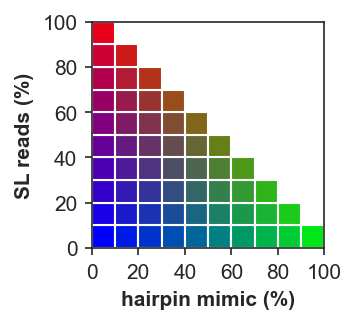

In [14]:
# This code allows to generate the colormap used in Figure 3.e

# Red = 100% SL reads
# Green = 100% mimic reads
# Blue = 100% unidentified reads

%matplotlib inline

sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(2,2), dpi=150)

for i in range(0,100,10):
    for j in range(0,100,10):
        
        # set Red value
        R = i/100 if i>0 else 0
        
        # set Green value
        G = j/100 if j>0 else 0
        
        if i+j < 100:
            
            # set Blue value
            B = 1-(R+G)
            
            # draw corresponding color
            ax.add_patch(Rectangle((j, i), 10, 10, facecolor=(R,G,B), edgecolor=None))



plt.tick_params(axis='both', which ='both', left=True, bottom=True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))


plt.xlim(0,100)
plt.ylim(0,100)
plt.ylabel('SL reads (%)', weight='bold')
plt.xlabel('hairpin mimic (%)', weight='bold')
        
plt.savefig('Fig6-color_legend.pdf', dpi=500)

<br>

# Single SL1 promotor: nlp-36 (B0464.3)

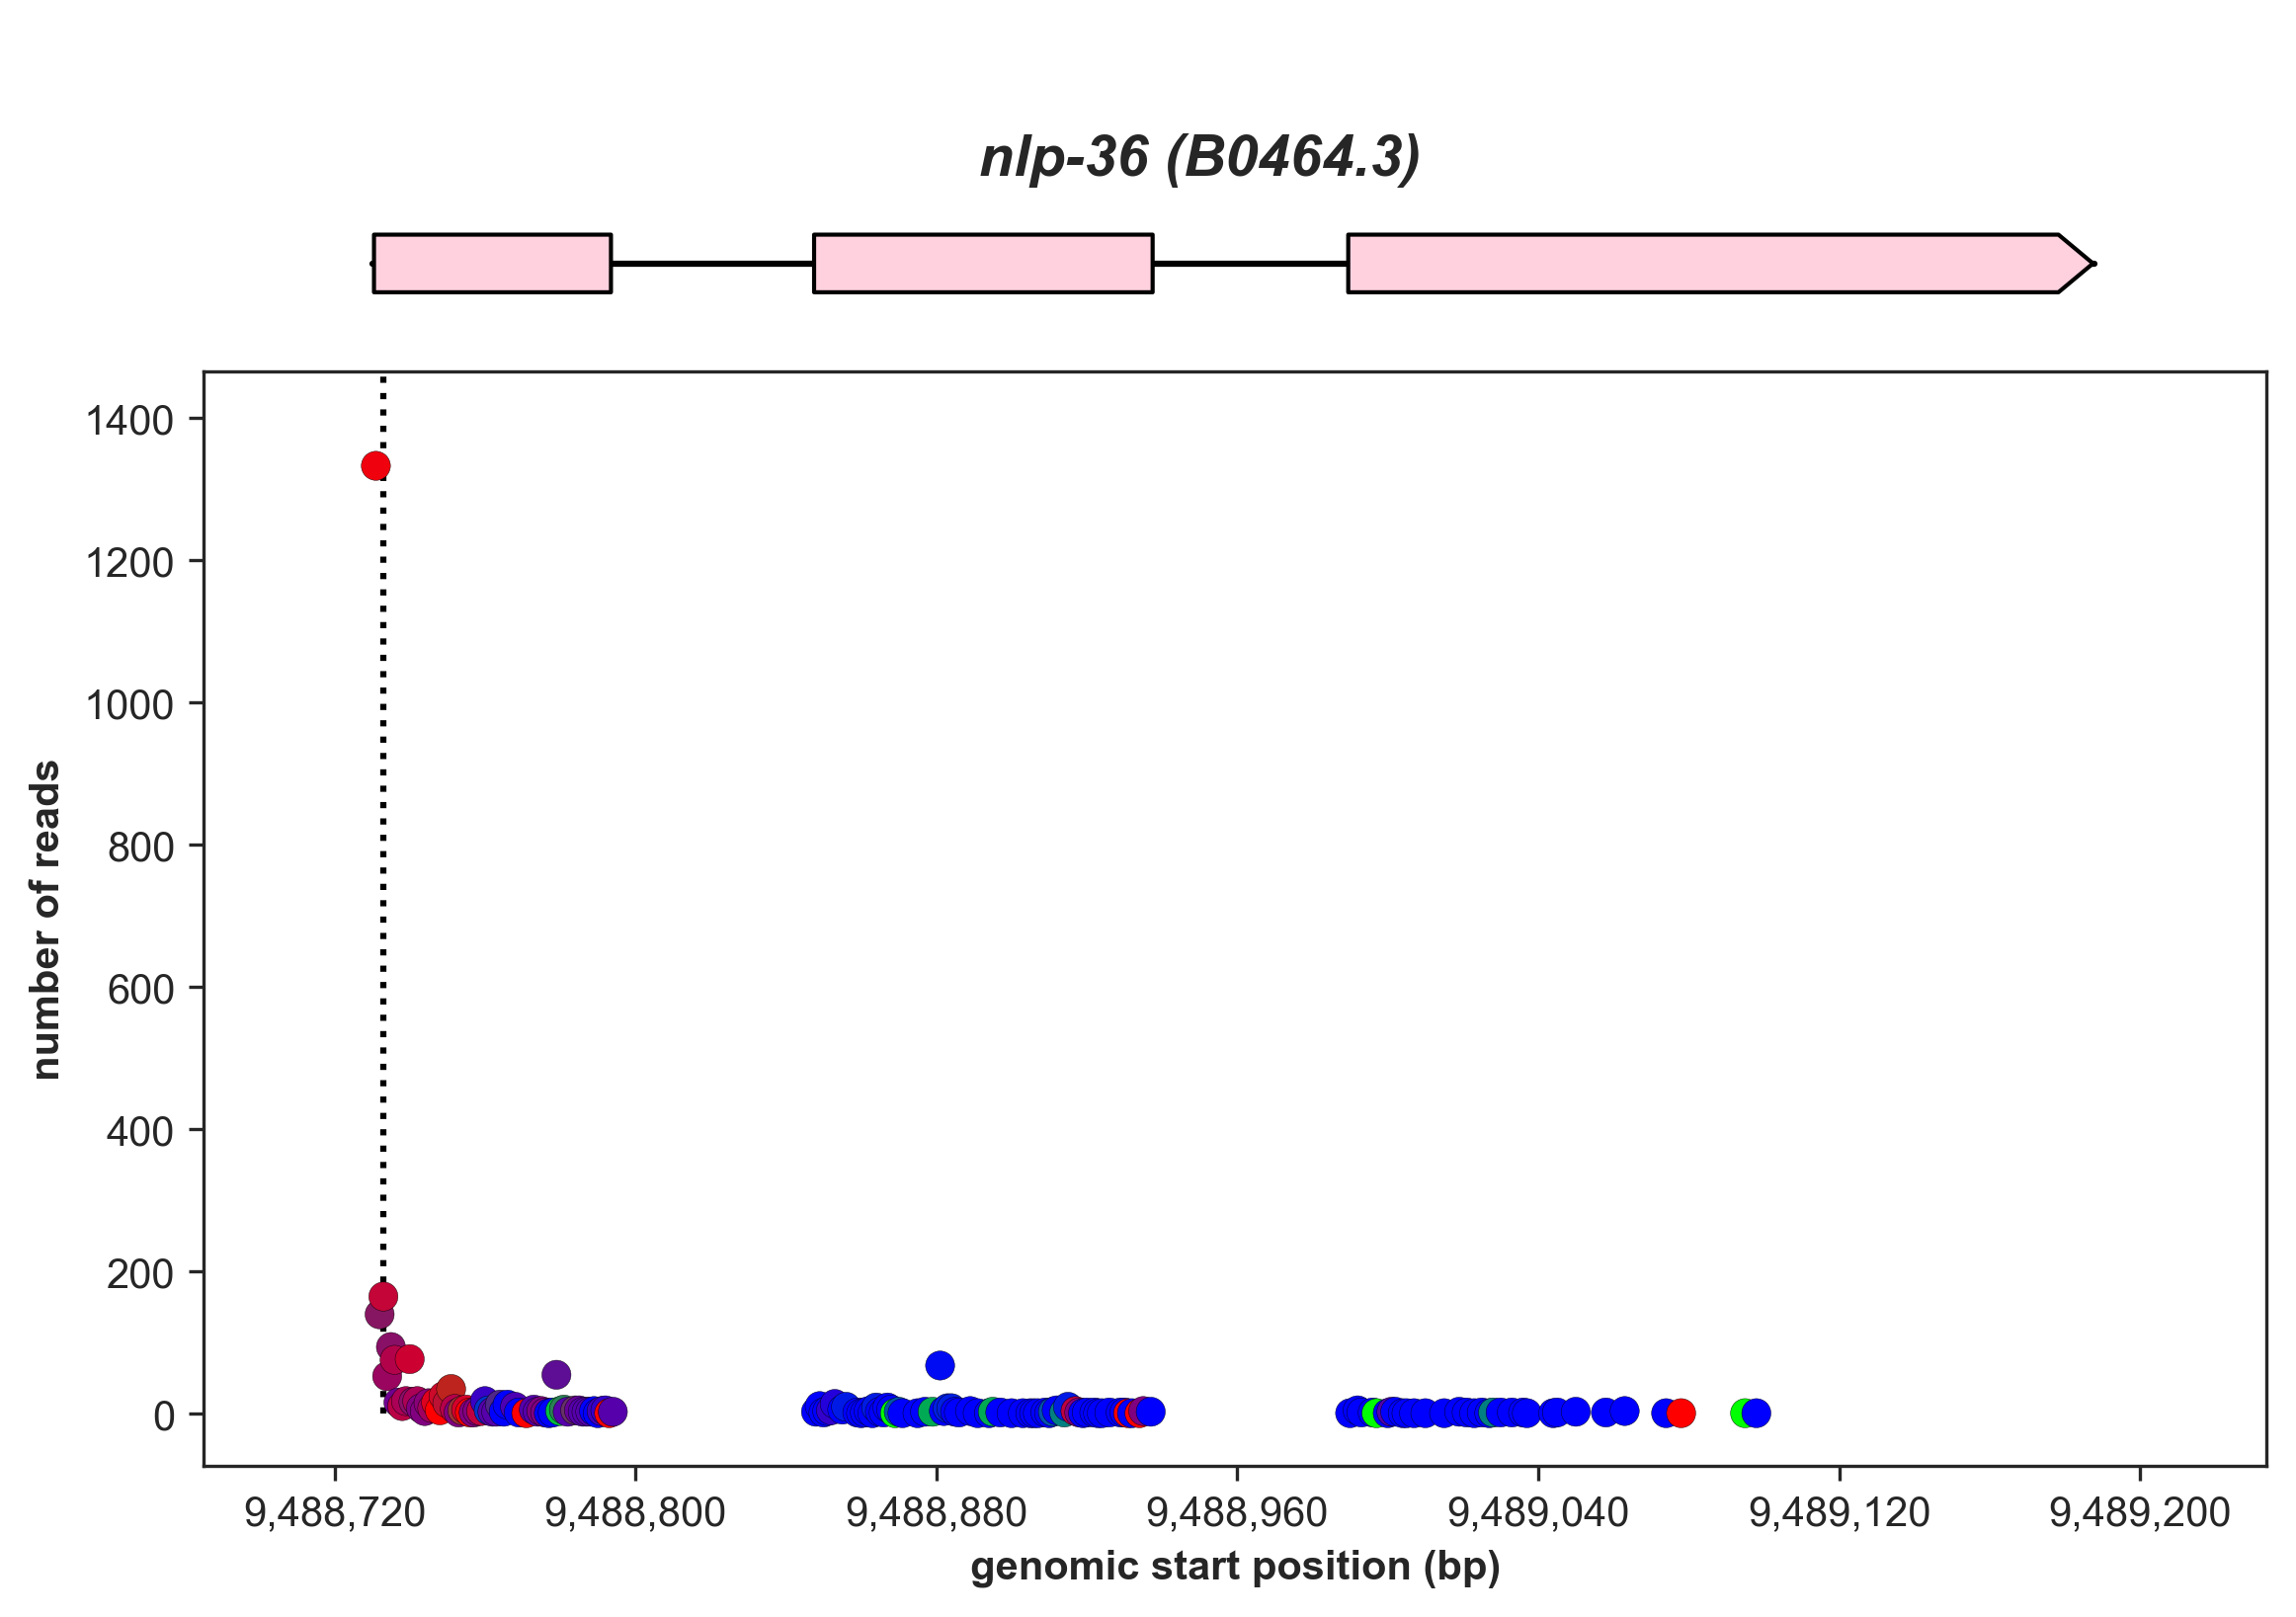

In [15]:
gene_start_positions('B0464.3', output='Fig6-single_SL1_promoter.png')
plt.show()

<font size="4">**Figure 6:**<br></font>
Schematic representation of various genes showing different modes of trans-splicing. Each alignment start position observed was plotted at the corresponding genomic position with the number of supporting reads. The dots are colored according to the observed trans-splicing events with red indicating a majority of SL reads, green a majority of endogenous hairpin reads and blue reads with no evidence for either.<br>
**nlp-36 (B0464.3):** Single SL1 promotor.

<br>

# Multiple SL1 promotors: M60.4

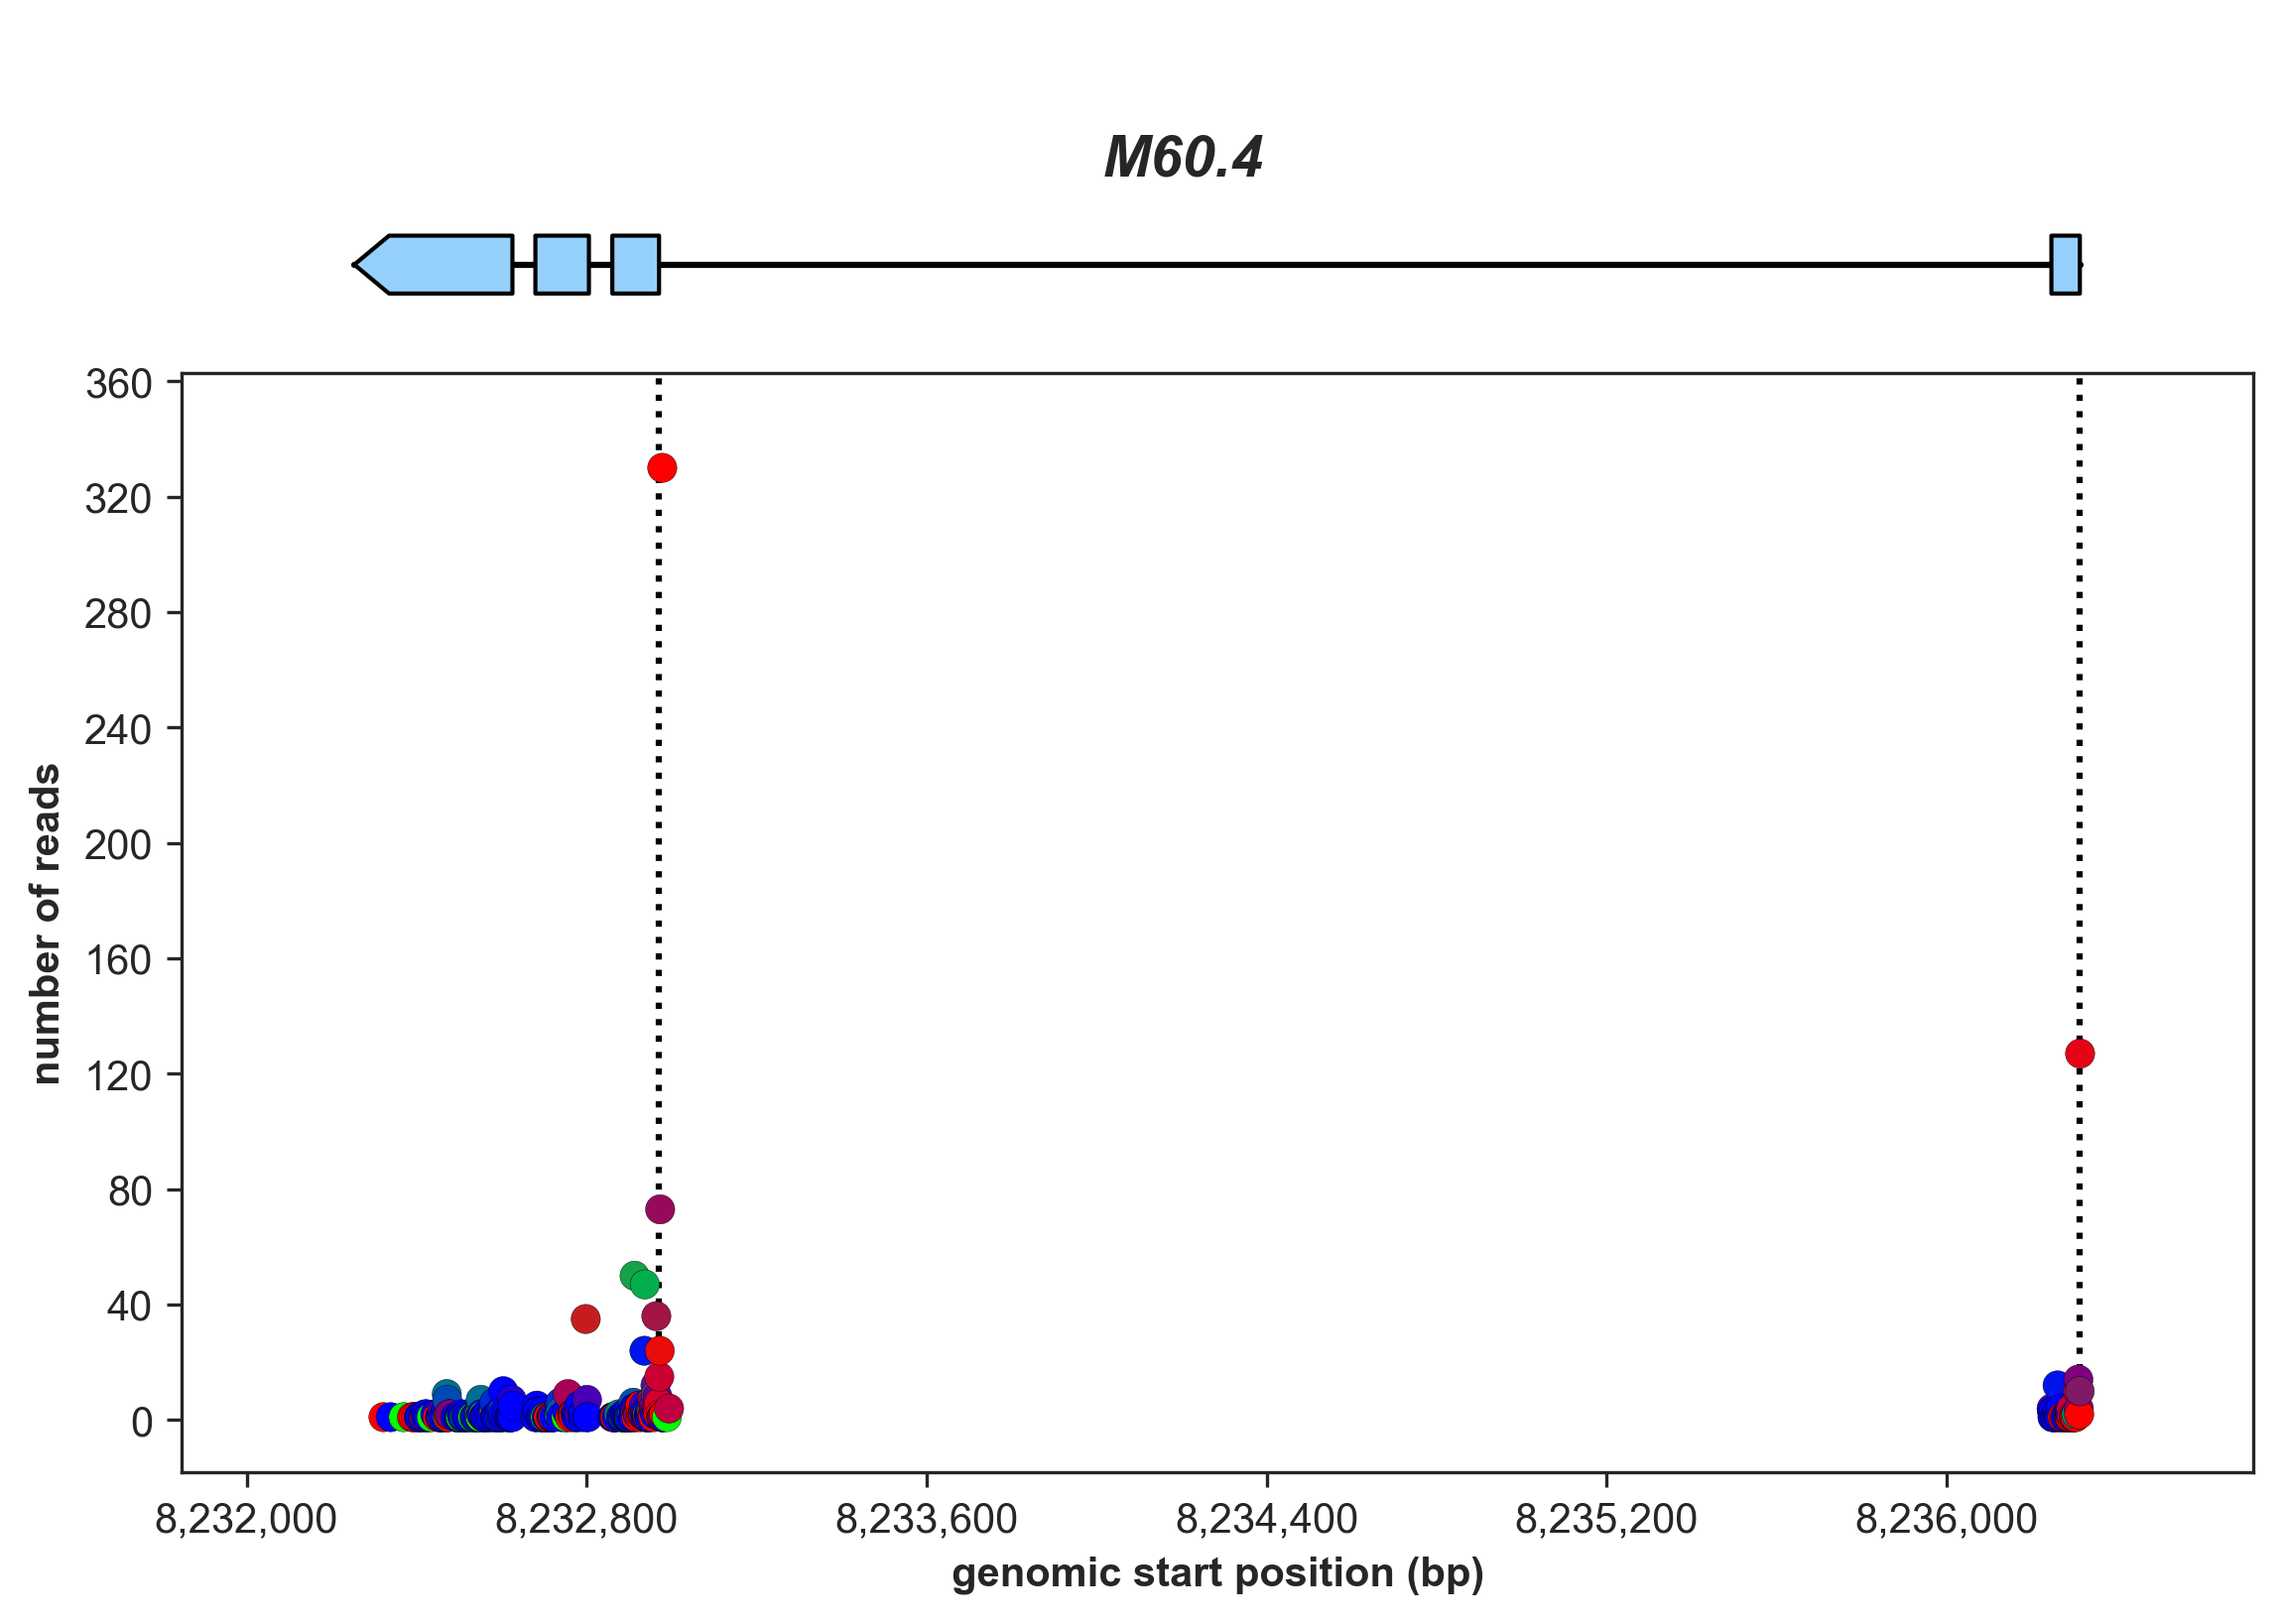

In [16]:
gene_start_positions('M60.4', output='Fig6-multiple_SL1_promoters.png')
plt.show()

<font size="4">**Figure 6:**<br></font>
Schematic representation of various genes showing different modes of trans-splicing. Each alignment start position observed was plotted at the corresponding genomic position with the number of supporting reads. The dots are colored according to the observed trans-splicing events with red indicating a majority of SL reads, green a majority of endogenous hairpin reads and blue reads with no evidence for either.<br>
**M60.4:** Multiple SL1 promotors.

<br>

# Operon organization: Y37E3.8 & Y37E3.7

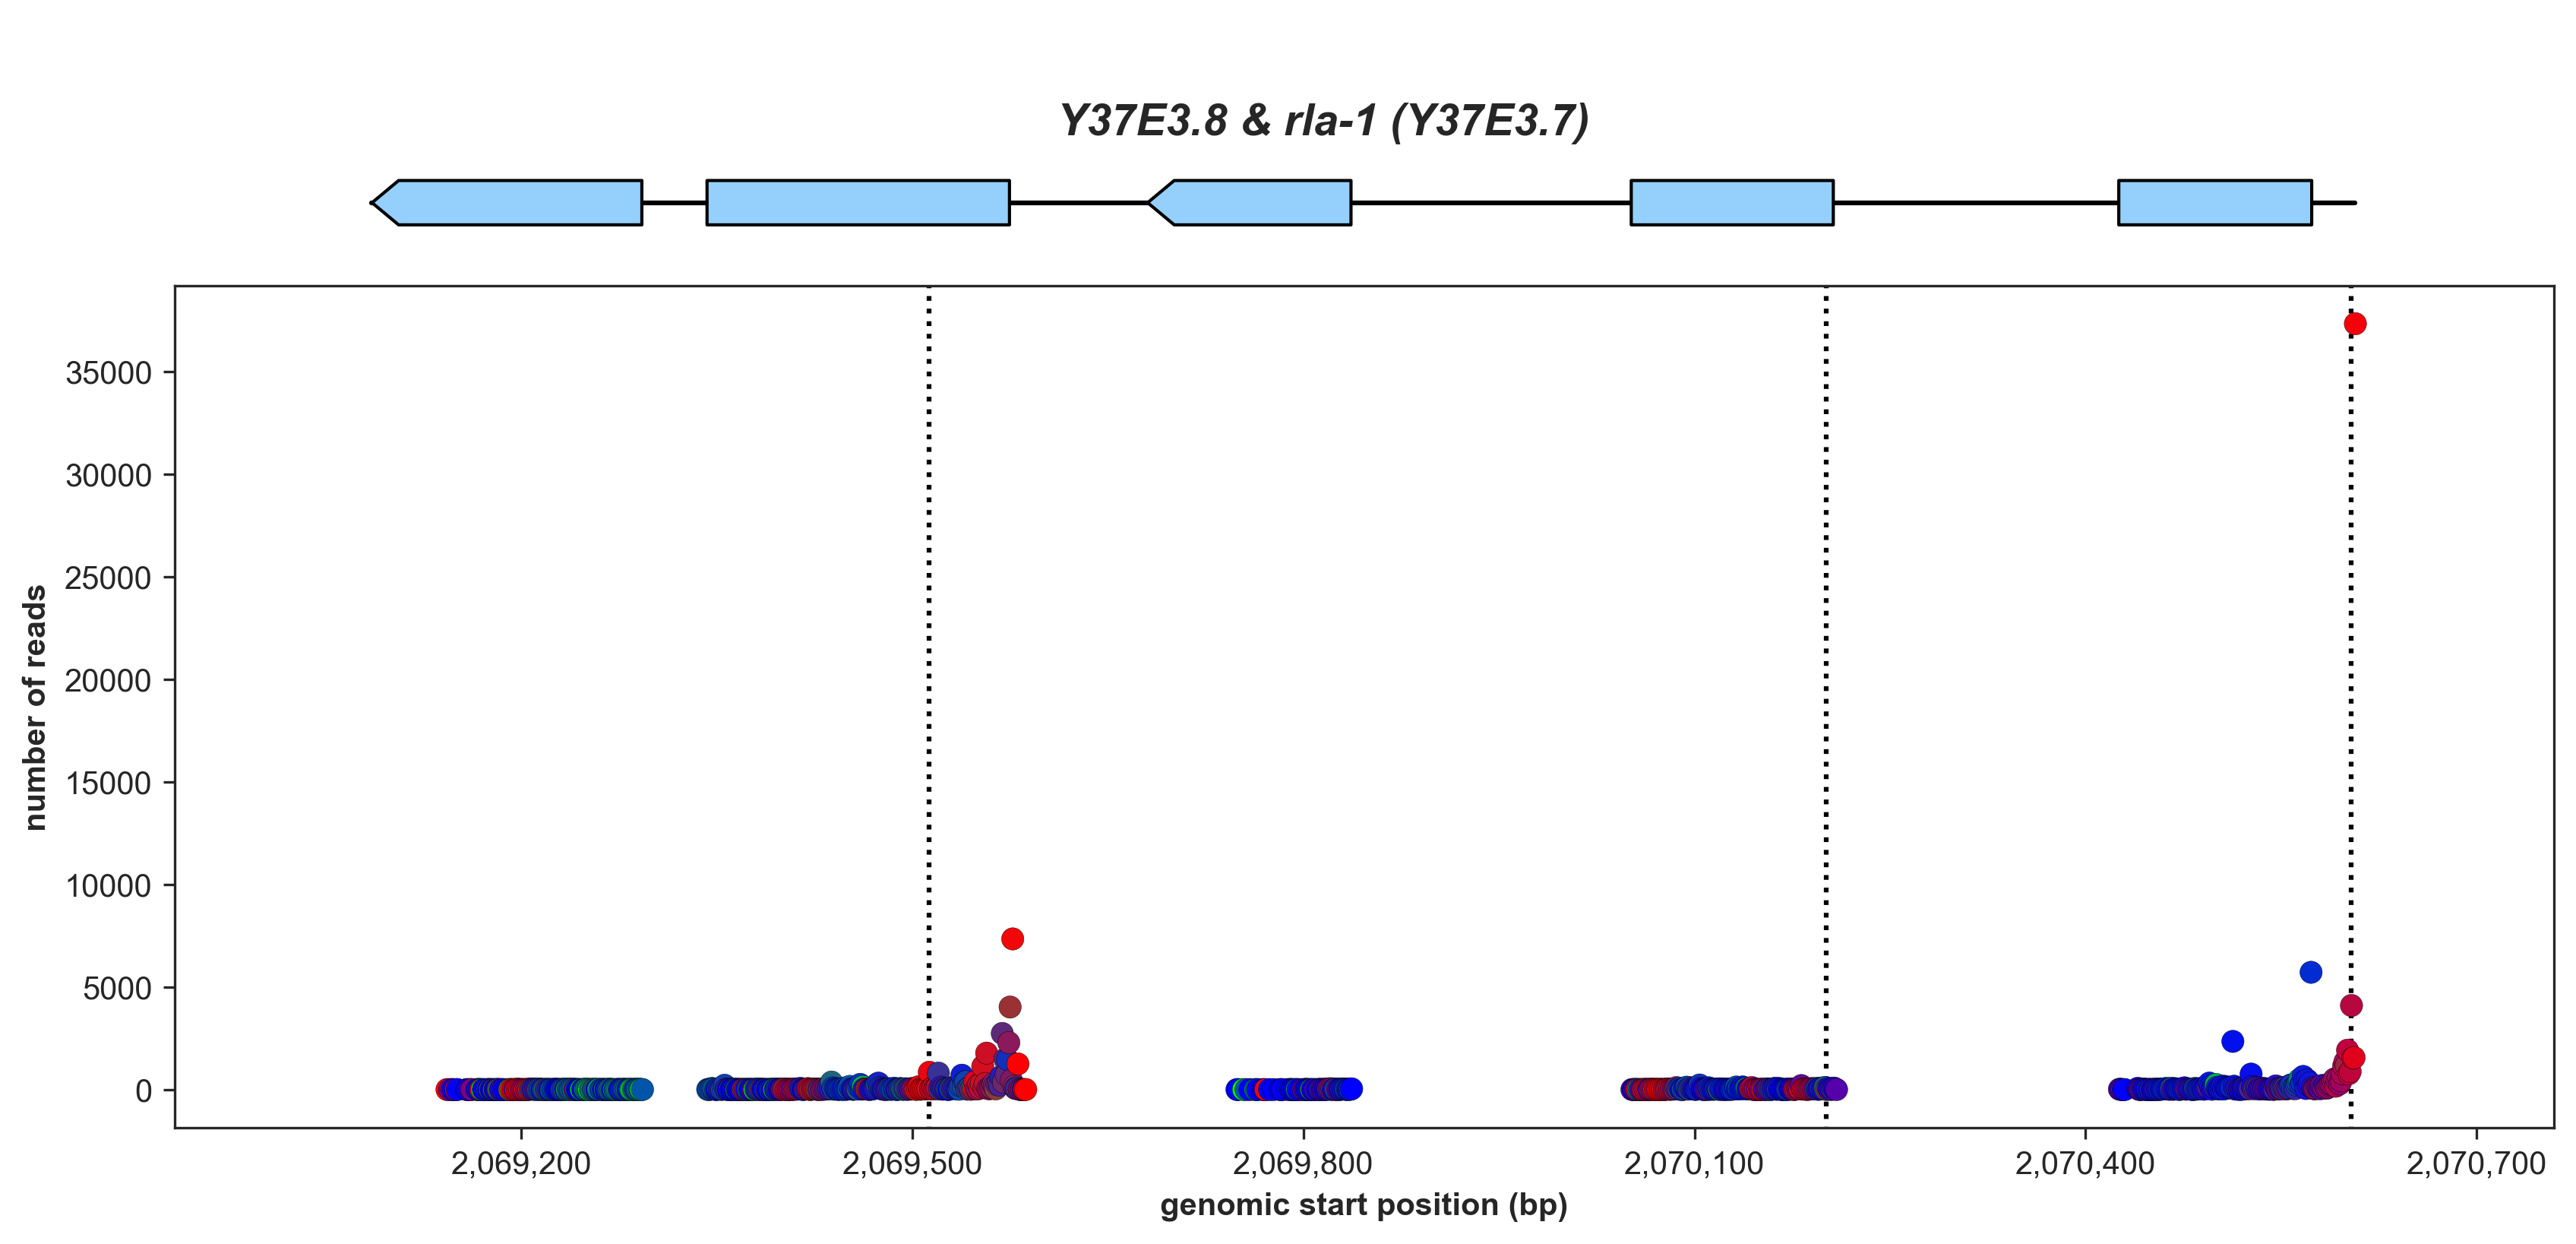

In [17]:
plot_operon('Y37E3.8', 'Y37E3.7', output='Fig6-operon.png')
plt.show()

<font size="4">**Figure 6:**<br></font>
Schematic representation of various genes showing different modes of trans-splicing. Each alignment start position observed was plotted at the corresponding genomic position with the number of supporting reads. The dots are colored according to the observed trans-splicing events with red indicating a majority of SL reads, green a majority of endogenous hairpin reads and blue reads with no evidence for either.<br>
**rla-1 (Y37E3.7) & Y37E3.8:** Operon-like system. Upstream gene is SL1 trans-spliced and downstream gene is SL2 trans-spliced.<br>Genes are located 104nt from each other.

<br>

# Differentially trans-spliced promoters : lev-11 (Y105E8B.1)

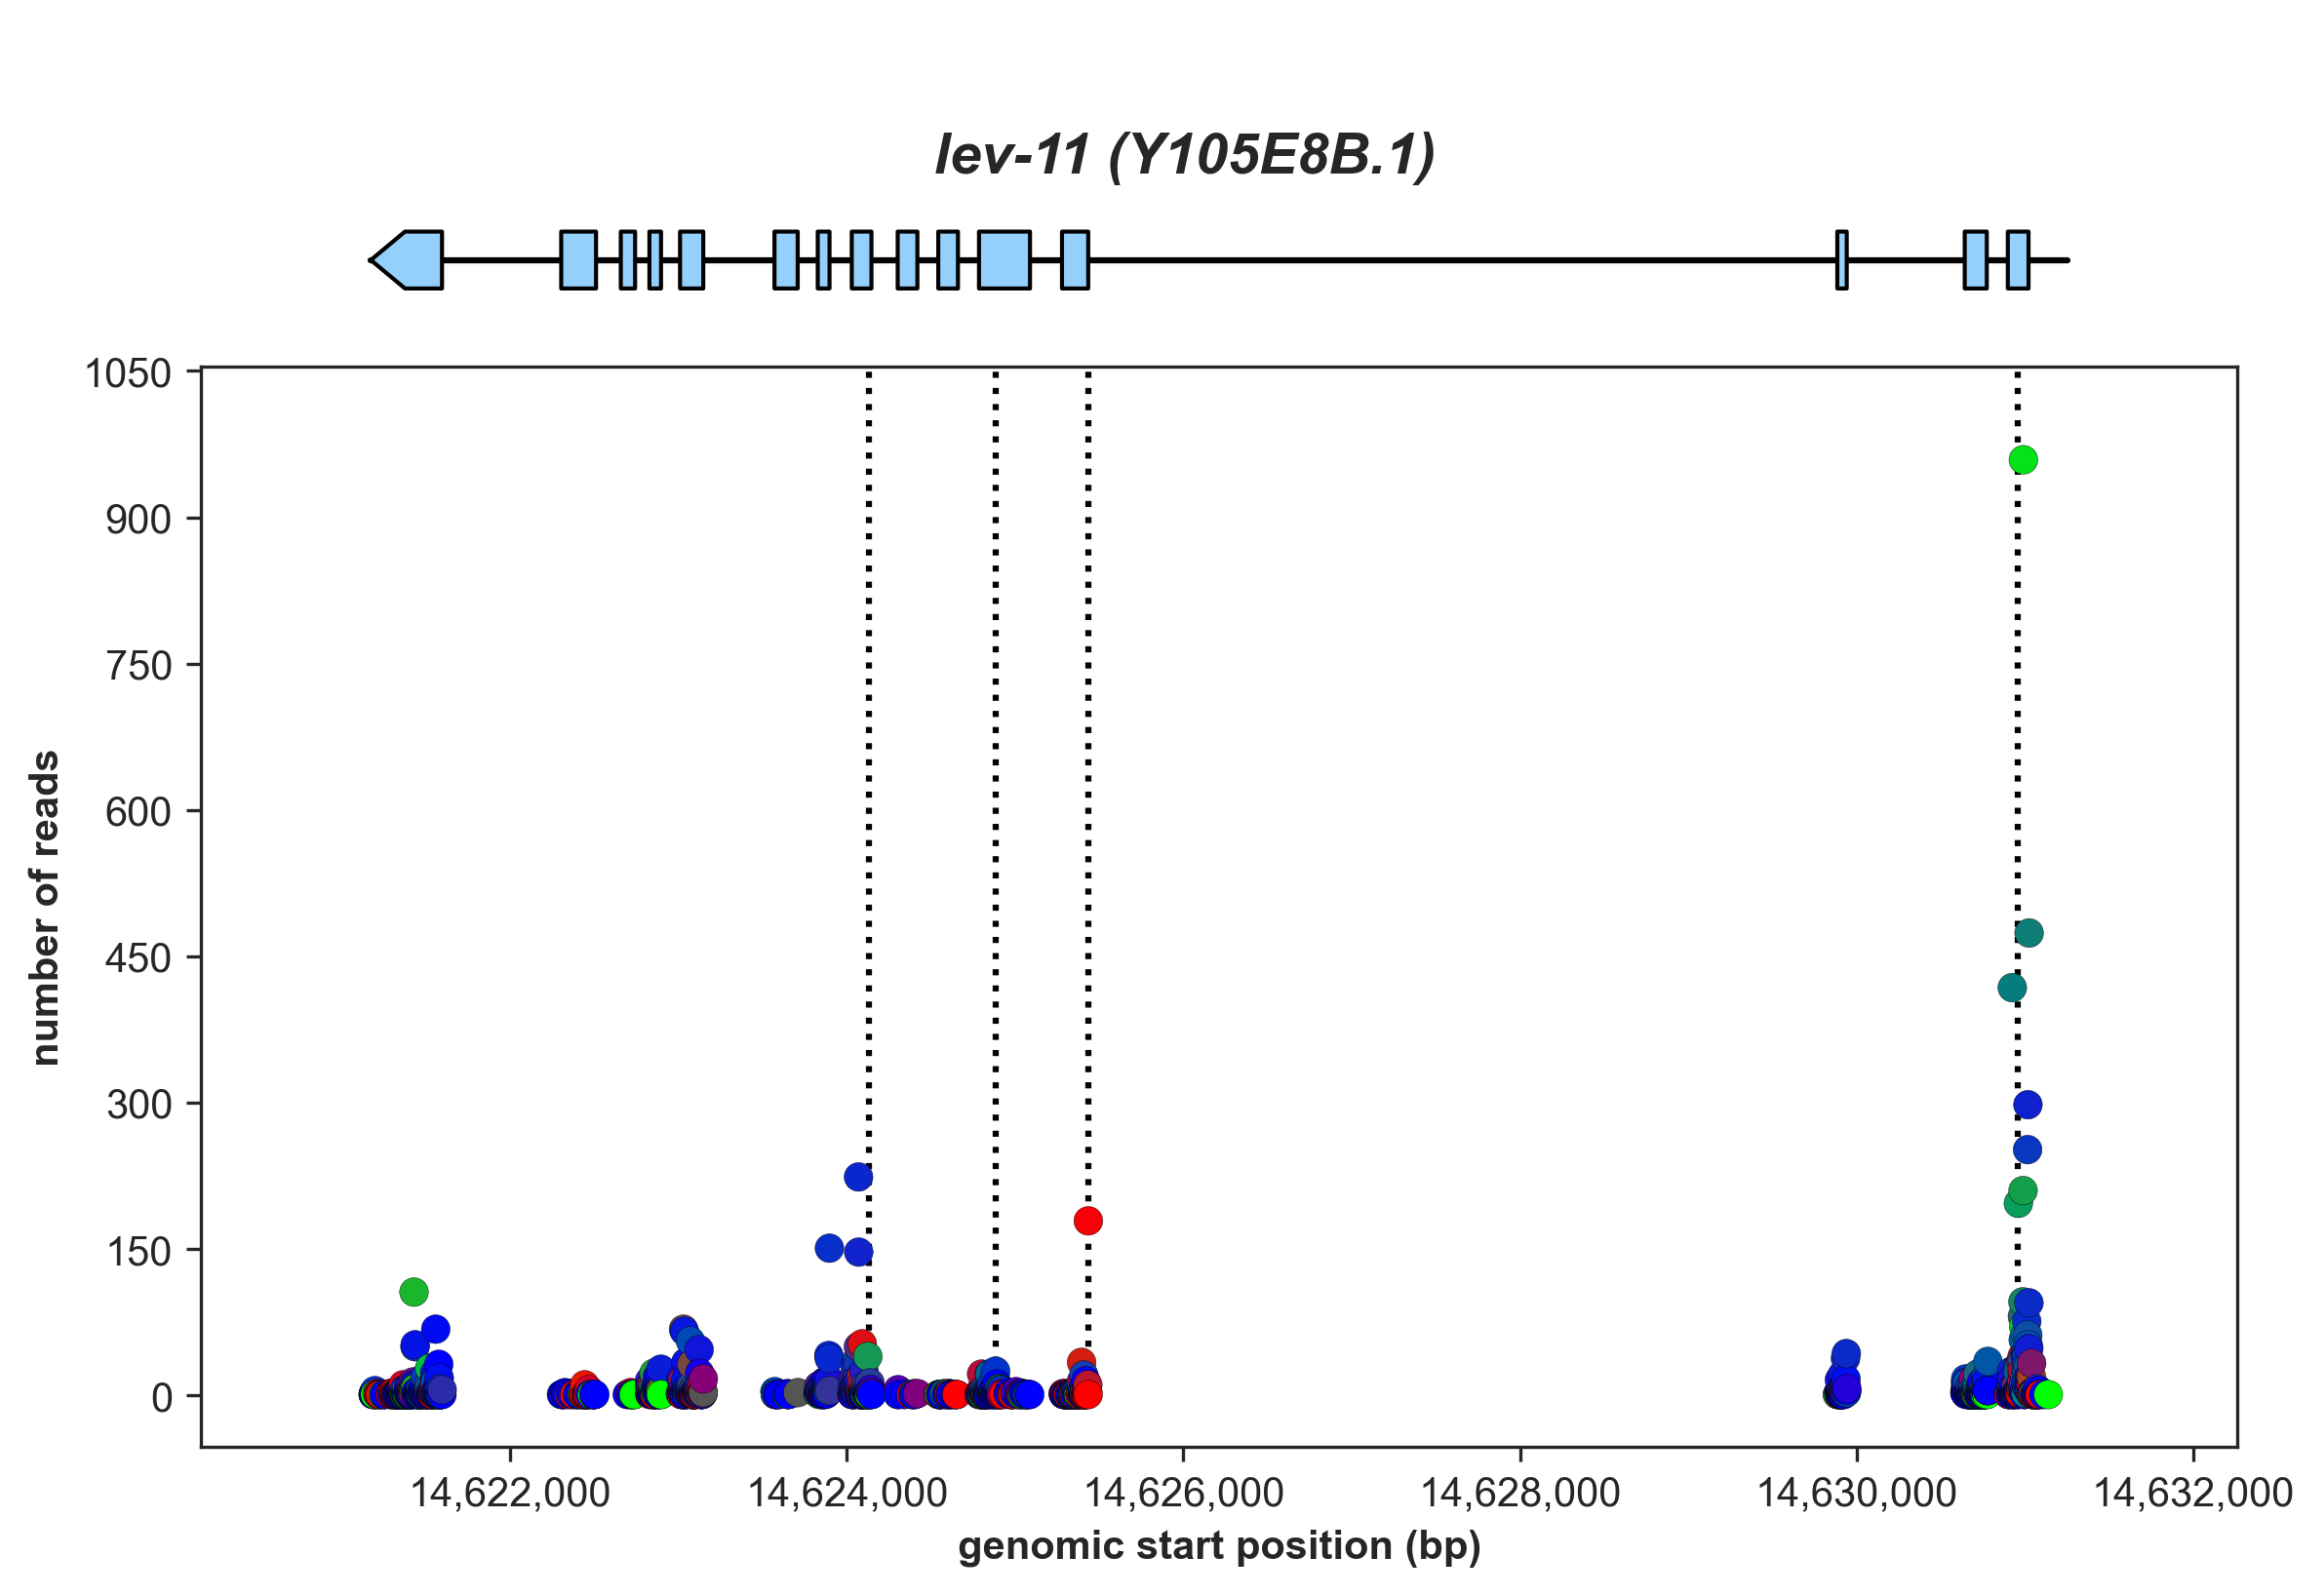

In [18]:
gene_start_positions('Y105E8B.1', output='Fig6-differentially_trans-spliced_promoters.png')
plt.show()

<font size="4">**Figure 6:**<br></font>
Schematic representation of various genes showing different modes of trans-splicing. Each alignment start position observed was plotted at the corresponding genomic position with the number of supporting reads. The dots are colored according to the observed trans-splicing events with red indicating a majority of SL reads, green a majority of endogenous hairpin reads and blue reads with no evidence for either.<br>
**lev-11 (Y105E8B.1):** Differentially trans-spliced promotors. 